## NICE Biz info - 기업별 연봉현황 및 산업현황 데이터  크롤링
- https://www.nicebizinfo.com/cm/CM0100M001GE.nice
- **address**: 주소 / **industry**: 산업 / **ind_rank**: 산업평가종합등급 / **payroll**: 평균연봉 / **new_payroll**: 올해입사자 평균연봉 /**employee**: 종업원수 / **employment**: 입사율(연간입사자) / **resignation**: 퇴사율(연간퇴사자) / **cmp_years**: 업력
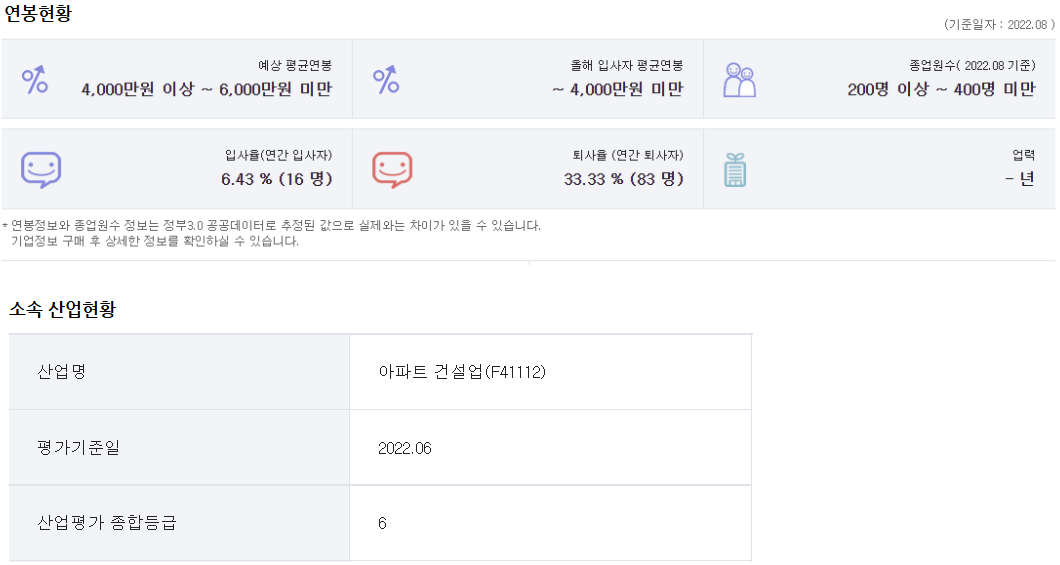

In [3]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
import time
import warnings
warnings.filterwarnings('ignore')

### 1) 재무데이터 사업자등록번호 불러오기 : 총 35,709개 (중복제거)

In [8]:
financial_data = pd.read_csv('data/재무데이터.txt', sep = "\t", encoding = "cp949", index_col=0)
f_index = financial_data.index.unique()
f_index

Int64Index([1018100340, 1018100772, 1018101126, 1018101242, 1018103819,
            1018104477, 1018104991, 1018106586, 1018115921, 1018116478,
            ...
            8988601448, 8988800633, 8988800759, 8998600312, 8998600665,
            8998700283, 8998701263, 8998800150, 8998800427, 8998800785],
           dtype='int64', name='사업자번호', length=35709)

### 2) 크롤링 코드

In [199]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
driver.implicitly_wait(10)
time.sleep(0.2)
c_data = []

for i in range(len(f_index)):
    url = f'https://www.nicebizinfo.com/ep/EP0100M001GE.nice?itgSrch={str(f_index[i])}'
    driver.get(url)
    driver.implicitly_wait(10)
    time.sleep(0.2)
    try:        
        driver.find_element(By.CSS_SELECTOR,'td.no_result')
        address = industry = ind_rank = payroll = new_payroll = employee = employment = resignation = cmp_years = ''
        c_data.append([address, industry, ind_rank, payroll, new_payroll, employee, employment, resignation, cmp_years])
    except:
        try:
            driver.find_element(By.CSS_SELECTOR,'td.tar.bdr1').click()
            driver.implicitly_wait(10)
            time.sleep(0.2)
            page_source = driver.page_source 
            soup = bs(page_source, 'lxml')
            address = soup.select('div.iconBox.bg2 strong')[0].text
            industry = soup.select('div.iconBox.bg5 strong')[0].text
            try:
                rank = soup.select('div.cTable.sp2')[1]
                ind_rank = rank.select('td')[3].text.strip()        
            except:
                ind_rank = ''
            try: 
                table = soup.select('.cSection strong.fz16')
                payroll = table[0].text.strip()
                new_payroll = table[1].text.strip()
                employee = table[2].text.strip()
                employment = table[3].text.strip().replace('\n','')
                resignation = table[4].text.strip().replace('\n','')
                cmp_years = table[5].text.strip()
            except:
                payroll = new_payroll = employee = employment = resignation = cmp_years = ''    
            c_data.append([address, industry, ind_rank, payroll, new_payroll, employee, employment, resignation, cmp_years])   
        except:
            driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
            driver.implicitly_wait(10)
            time.sleep(0.2)
            driver.get(url)
            driver.implicitly_wait(10)
            time.sleep(0.2)
            address = driver.find_element(By.CSS_SELECTOR,'li.addr').text
            industry = driver.find_element(By.CSS_SELECTOR,'span.fll.textLeftBg.gear').text
            ind_rank = payroll = new_payroll = employee = employment = resignation = cmp_years = ''
            c_data.append([address, industry, ind_rank, payroll, new_payroll, employee, employment, resignation, cmp_years])
            
driver.quit()

[WDM] - Downloading: 100%|████████████████████████████████████████████████████████| 6.29M/6.29M [00:00<00:00, 7.98MB/s]
[WDM] - Downloading: 100%|████████████████████████████████████████████████████████| 6.29M/6.29M [00:00<00:00, 9.14MB/s]


### 3) 데이터 저장 : bizinfo_df.xlsx

In [220]:
bizinfo_df = pd.DataFrame(c_data, columns=['address', 'industry', 'ind_rank', 'payroll', 'new_payroll', 'employee', 'employment', 'resignation', 'cmp_years'])
bizinfo_df.index = f_index
bizinfo_df.to_excel('bizinfo_df.xlsx')

In [4]:
bizinfo_df = pd.read_excel('bizinfo_df.xlsx')
bizinfo_df.head(10)

,사업자번호,address,industry,ind_rank,payroll,new_payroll,employee,employment,resignation,cmp_years
0,1018100340,서울 종로구 삼일대로 428,비주거용 건물 임대업,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1018100772,서울 종로구 청계천로 137,(I55101)호텔업,5.0,"~ 4,000만원 미만","~ 4,000만원 미만",-,0.00 % (0 ...,0.00 % (0 ...,53 년
2,1018101126,서울 종로구 율곡로 84,(L68112)비주거용 건물 임대업,6.0,"~ 4,000만원 미만","~ 4,000만원 미만",1명 이상 ~ 20명 미만,80.00 % (4 ...,60.00 % (3 ...,55 년
3,1018101242,서울 종로구 종로12길 15,(L68112)비주거용 건물 임대업,6.0,"~ 4,000만원 미만","~ 4,000만원 미만",1명 이상 ~ 20명 미만,12.50 % (1 ...,25.00 % (2 ...,- 년
4,1018103819,서울 종로구 종로 125,(L68112)비주거용 건물 임대업,6.0,"~ 4,000만원 미만","~ 4,000만원 미만",-,0.00 % (0 ...,0.00 % (0 ...,- 년
5,1018104477,서울 종로구 종로 65,(R91121)골프장 운영업,5.0,"4,000만원 이상 ~ 6,000만원 미만","~ 4,000만원 미만",100명 이상 ~ 200명 미만,18.56 % (18 ...,28.87 % (28 ...,66 년
6,1018104991,서울 중구 퇴계로36가길 104,(M72111)건축설계 및 관련 서비스업,7.0,"4,000만원 이상 ~ 6,000만원 미만","~ 4,000만원 미만",70명 이상 ~ 100명 미만,30.34 % (27 ...,31.46 % (28 ...,50 년
7,1018106586,서울 구로구 경인로53길 15,그 외 기타 기계 및 장비 도매업,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1018115921,경기 의왕시 오봉산단1로 64,(G46109)상품 종합 중개업,5.0,"~ 4,000만원 미만","~ 4,000만원 미만",20명 이상 ~ 40명 미만,19.23 % (5 ...,23.08 % (6 ...,- 년
9,1018116478,서울 종로구 청계천로 151-7,(G46595)전기용 기계ㆍ장비 및 관련 기자재 도매업,5.0,"4,000만원 이상 ~ 6,000만원 미만","~ 4,000만원 미만",40명 이상 ~ 70명 미만,9.30 % (4 ...,4.65 % (2 ...,39 년


### 4) 결측치 확인

### - 사업자등록번호 조회시, 기업 검색결과가 부재한 경우 : 1,380개

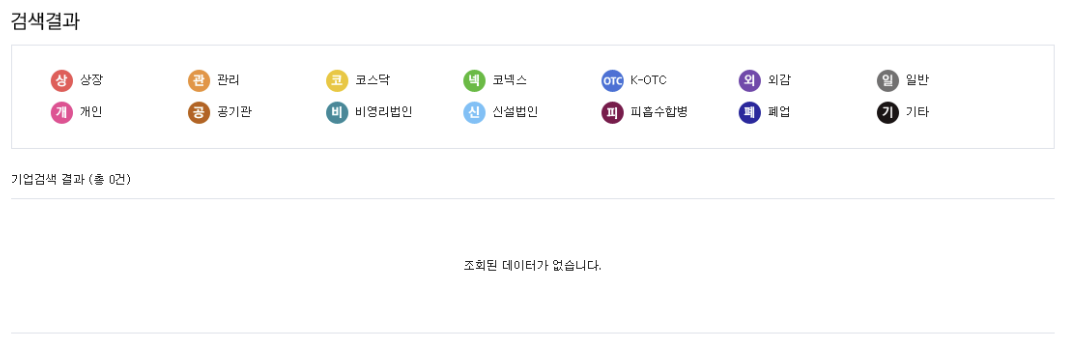

In [208]:
bizinfo_df.isnull().sum()

사업자번호             0
address        1380
industry       1379
ind_rank       4409
payroll        7653
new_payroll    7653
employee       7653
employment     7653
resignation    7653
cmp_years      7653
dtype: int64

### - 조회는 되지만 주소가 없는 경우 : 1개
- address	1380, industry	1379로 1개의 차이가 나는 이유

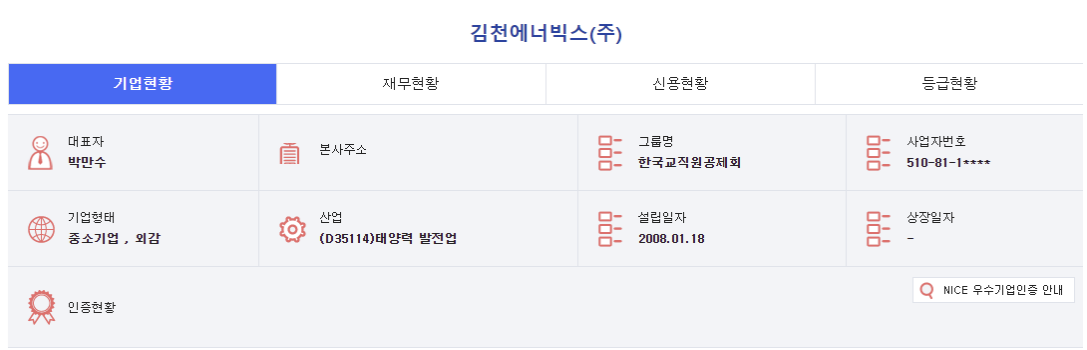

In [33]:
bizinfo_df[(bizinfo_df['address'].isnull()) & (bizinfo_df['industry'].notnull())]

,사업자번호,address,industry,ind_rank,payroll,new_payroll,employee,employment,resignation,cmp_years
26502,5108119835,NaN,(D35114)태양력 발전업,5.0,NaN,NaN,NaN,NaN,NaN,NaN


### - 주소, 산업분류는 있지만 기업정보 상세보기(연봉현황 및 산업현황 데이터)가 존재하지 않는 경우 : 6,274개

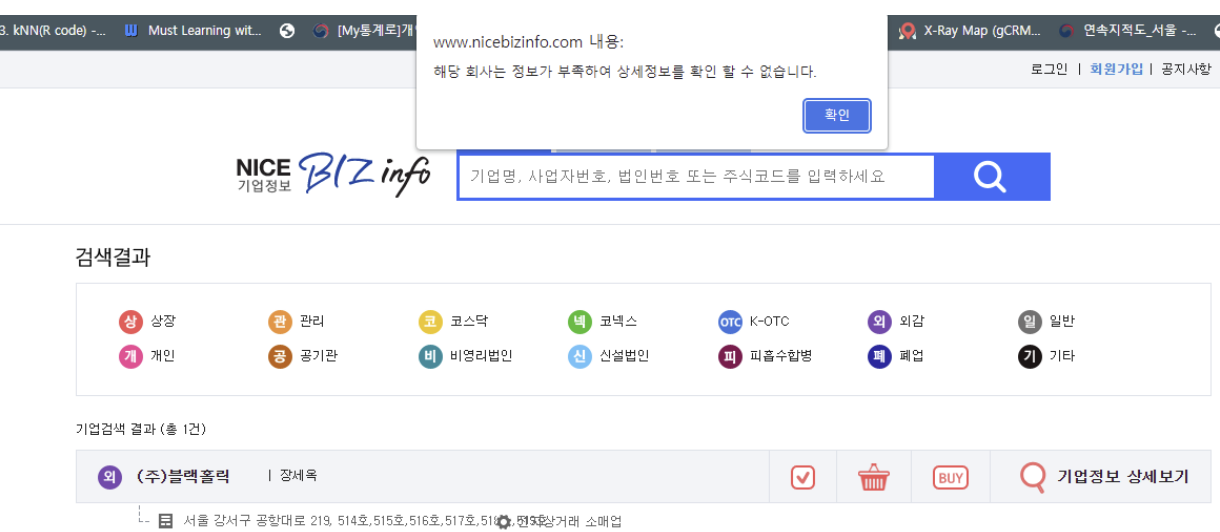

In [37]:
bizinfo_df[(bizinfo_df['payroll'].isnull()) & (bizinfo_df['industry'].notnull())]

,사업자번호,address,industry,ind_rank,payroll,new_payroll,employee,employment,resignation,cmp_years
0,1018100340,서울 종로구 삼일대로 428,비주거용 건물 임대업,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1018106586,서울 구로구 경인로53길 15,그 외 기타 기계 및 장비 도매업,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,1018119209,"서울 서대문구 서소문로 61-1, 303호",(I56123)서양식 음식점업,5.0,NaN,NaN,NaN,NaN,NaN,NaN
26,1018132686,"서울 성동구 성수이로 118, 1421호",(L68112)비주거용 건물 임대업,6.0,NaN,NaN,NaN,NaN,NaN,NaN
34,1018138657,"서울 중구 청계천로 100, 동관 15층",광고 대행업,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
35685,8978601542,"서울 서초구 강남대로 465, 20층",(L68122)비주거용 건물 개발 및 공급업,6.0,NaN,NaN,NaN,NaN,NaN,NaN
35701,8988800759,경기 김포시 대곶면 율마로 26,고체연료 및 관련제품 도매업,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35703,8998600665,경남 양산시 어실로 461-1,(H52101)일반 창고업,6.0,NaN,NaN,NaN,NaN,NaN,NaN
35705,8998701263,서울 영등포구 의사당대로 82,(K66199)그 외 기타 금융 지원 서비스업,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### - 주소, 산업분류, 연봉현황은 있지만  산업현황 데이터가 존재하지 않는 경우 : 397개
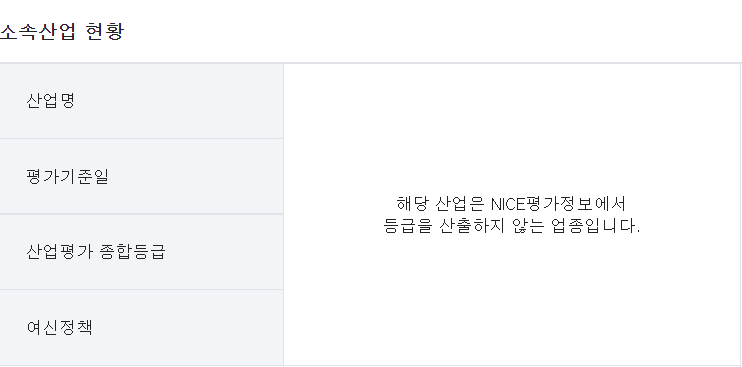

In [39]:
bizinfo_df[(bizinfo_df['ind_rank'].isnull()) & (bizinfo_df['payroll'].notnull())]

,사업자번호,address,industry,ind_rank,payroll,new_payroll,employee,employment,resignation,cmp_years
56,1018152794,"서울 중구 을지로5길 26, 서관 7층",(K66202)보험 대리 및 중개업,NaN,"4,000만원 이상 ~ 6,000만원 미만","~ 4,000만원 미만",20명 이상 ~ 40명 미만,36.67 % (11 ...,16.67 % (5 ...,- 년
75,1018164892,"서울 종로구 우정국로 26, 11층",(K66121)증권 중개업,NaN,"4,000만원 이상 ~ 6,000만원 미만","4,000만원 이상 ~ 6,000만원 미만",20명 이상 ~ 40명 미만,20.51 % (8 ...,25.64 % (10 ...,22 년
87,1018177155,대구 동구 장등로 86,(K64992)지주회사,NaN,"~ 4,000만원 미만","~ 4,000만원 미만",1명 이상 ~ 20명 미만,33.33 % (1 ...,33.33 % (1 ...,21 년
91,1018179639,"서울 종로구 우정국로 26, 11층",(K64201)신탁업 및 집합투자업,NaN,"4,000만원 이상 ~ 6,000만원 미만","4,000만원 이상 ~ 6,000만원 미만",20명 이상 ~ 40명 미만,24.32 % (9 ...,21.62 % (8 ...,20 년
102,1018187707,"서울 영등포구 국제금융로 10, 30층",(K66121)증권 중개업,NaN,"4,000만원 이상 ~ 6,000만원 미만","4,000만원 이상 ~ 6,000만원 미만",40명 이상 ~ 70명 미만,20.00 % (9 ...,11.11 % (5 ...,20 년
...,...,...,...,...,...,...,...,...,...,...
35281,8578800404,"서울 강남구 논현로111길 23, 5층",(K64919)그 외 기타 여신금융업,NaN,"~ 4,000만원 미만","~ 4,000만원 미만",1명 이상 ~ 20명 미만,0.00 % (0 ...,100.00 % (7 ...,6 년
35475,8768801189,"서울 강남구 선릉로125길 5, 3층",(K64919)그 외 기타 여신금융업,NaN,"~ 4,000만원 미만","~ 4,000만원 미만",1명 이상 ~ 20명 미만,33.33 % (2 ...,0.00 % (0 ...,4 년
35496,8788801680,전북 남원시 사매면 산단로 98-39,(C23122)디스플레이 장치용 유리 제조업,NaN,"4,000만원 이상 ~ 6,000만원 미만","4,000만원 이상 ~ 6,000만원 미만",40명 이상 ~ 70명 미만,35.90 % (14 ...,25.64 % (10 ...,2 년
35612,8908600708,"서울 마포구 마포대로 38, 1506호",(K64992)지주회사,NaN,"4,000만원 이상 ~ 6,000만원 미만","~ 4,000만원 미만",1명 이상 ~ 20명 미만,14.29 % (1 ...,28.57 % (2 ...,6 년


### 5) 데이터 전처리
### - 산업등급 ind_rank : (변경전) 숫자 클수록 해당 산업의 사업환경 불량 -> **(변경후)  숫자 클수록 사업환경 양호**
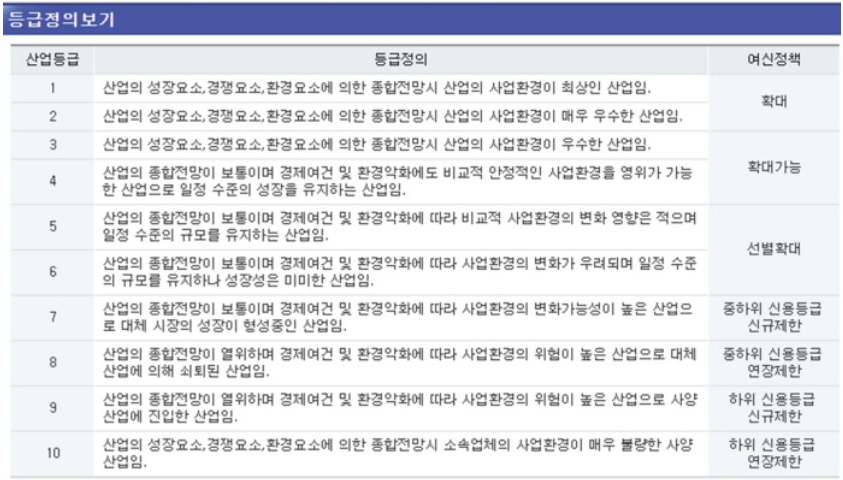

In [28]:
bizinfo_df['ind_rank'].value_counts()

6.0    15309
5.0    11312
4.0     2416
7.0     2221
3.0       32
8.0       10
Name: ind_rank, dtype: int64

In [236]:
for i in range(len(bizinfo_df['ind_rank'])):
    bizinfo_df['ind_rank'][i] = 10 - bizinfo_df['ind_rank'][i]
    
bizinfo_df['ind_rank'].value_counts()

4.0    15309
5.0    11312
6.0     2416
3.0     2221
7.0       32
2.0       10
Name: ind_rank, dtype: int64

In [29]:
bizinfo_df['ind_rank'].isnull().sum()               #결측치는 가장 하위값으로 필링하는 것이 어떰..?

4409

### - 평균연봉 payroll : 구간별 연봉 높을수록 큰 숫자 부여

In [44]:
bizinfo_df['payroll'].value_counts()

~ 4,000만원 미만               18960
4,000만원 이상 ~ 6,000만원 미만     8770
6,000만원 이상 ~ 8,000만원 미만      303
~ 1억 이상                       14
8,000만원 이상 ~ 1억 미만             9
Name: payroll, dtype: int64

In [237]:
bizinfo_df['payroll'].loc[bizinfo_df['payroll'] == '~ 4,000만원 미만'] = 1
bizinfo_df['payroll'].loc[bizinfo_df['payroll'] == '4,000만원 이상 ~ 6,000만원 미만'] = 2
bizinfo_df['payroll'].loc[bizinfo_df['payroll'] == '6,000만원 이상 ~ 8,000만원 미만'] = 3
bizinfo_df['payroll'].loc[bizinfo_df['payroll'] == '~ 1억 이상'] = 4
bizinfo_df['payroll'].loc[bizinfo_df['payroll'] == '8,000만원 이상 ~ 1억 미만'] = 5

bizinfo_df['payroll'].value_counts()

1    18960
2     8770
3      303
4       14
5        9
Name: payroll, dtype: int64

In [86]:
bizinfo_df['payroll'].isnull().sum()  

7653

### - 올해입사자 평균연봉 new_payroll : 구간별 연봉 높을수록 큰 숫자 부여

In [50]:
bizinfo_df['new_payroll'].value_counts()

~ 4,000만원 미만               26852
4,000만원 이상 ~ 6,000만원 미만     1187
6,000만원 이상 ~ 8,000만원 미만       14
~ 1억 이상                        2
8,000만원 이상 ~ 1억 미만             1
Name: new_payroll, dtype: int64

In [238]:
bizinfo_df['new_payroll'].loc[bizinfo_df['new_payroll'] == '~ 4,000만원 미만'] = 1
bizinfo_df['new_payroll'].loc[bizinfo_df['new_payroll'] == '4,000만원 이상 ~ 6,000만원 미만'] = 2
bizinfo_df['new_payroll'].loc[bizinfo_df['new_payroll'] == '6,000만원 이상 ~ 8,000만원 미만'] = 3
bizinfo_df['new_payroll'].loc[bizinfo_df['new_payroll'] == '~ 1억 이상'] = 4
bizinfo_df['new_payroll'].loc[bizinfo_df['new_payroll'] == '8,000만원 이상 ~ 1억 미만'] = 5

bizinfo_df['new_payroll'].value_counts()

1    26852
2     1187
3       14
4        2
5        1
Name: new_payroll, dtype: int64

In [88]:
bizinfo_df['new_payroll'].isnull().sum()  

7653

### - 종업원수 employee : 구간별 인원 많을수록 큰 숫자 부여

In [55]:
bizinfo_df['employee'].value_counts()

1명 이상 ~ 20명 미만        6834
20명 이상 ~ 40명 미만       5319
-                     4878
40명 이상 ~ 70명 미만       4524
100명 이상 ~ 200명 미만     2723
70명 이상 ~ 100명 미만      2228
200명 이상 ~ 400명 미만     1029
400명 이상 ~ 700명 미만      327
1,000명 이상              102
700명 이상 ~ 1000명 미만      92
Name: employee, dtype: int64

In [242]:
bizinfo_df['employee'].loc[bizinfo_df['employee'] == '1명 이상 ~ 20명 미만'] = 1
bizinfo_df['employee'].loc[bizinfo_df['employee'] == '20명 이상 ~ 40명 미만'] = 2
bizinfo_df['employee'].loc[bizinfo_df['employee'] == '40명 이상 ~ 70명 미만'] = 3
bizinfo_df['employee'].loc[bizinfo_df['employee'] == '70명 이상 ~ 100명 미만'] = 4
bizinfo_df['employee'].loc[bizinfo_df['employee'] == '100명 이상 ~ 200명 미만'] = 5
bizinfo_df['employee'].loc[bizinfo_df['employee'] == '200명 이상 ~ 400명 미만'] = 6
bizinfo_df['employee'].loc[bizinfo_df['employee'] == '400명 이상 ~ 700명 미만'] = 7
bizinfo_df['employee'].loc[bizinfo_df['employee'] == '700명 이상 ~ 1000명 미만'] = 8
bizinfo_df['employee'].loc[bizinfo_df['employee'] == '1,000명 이상'] = 9
bizinfo_df['employee'].loc[bizinfo_df['employee'] == '- '] = np.nan

bizinfo_df['employee'].value_counts()

1    6834
2    5319
3    4524
5    2723
4    2228
6    1029
7     327
9     102
8      92
Name: employee, dtype: int64

In [243]:
bizinfo_df['employee'].isnull().sum()  

12531

### - 입사율 employment  : 총 직원수 대비 연간 입사자 비율만 남기고 제거

In [54]:
bizinfo_df['employment'].value_counts()

0.00 % (0                                            명)       6787
25.00 % (1                                            명)       188
33.33 % (1                                            명)       184
20.00 % (1                                            명)       169
16.67 % (1                                            명)       113
                                                              ... 
72.82 % (75                                            명)        1
265.52 % (77                                            명)       1
38.24 % (26                                            명)        1
153.33 % (46                                            명)       1
6.25 % (5                                            명)          1
Name: employment, Length: 6927, dtype: int64

In [240]:
for i in range(len(bizinfo_df['employment'])):
    bizinfo_df['employment'][i] = str(bizinfo_df['employment'][i]).split('%')[0]

bizinfo_df['employment'].value_counts()

nan       7653
0.00      7053
33.33      544
25.00      474
20.00      425
          ... 
58.18        1
67.59        1
12.21        1
35.66        1
64.15        1
Name: employment, Length: 4403, dtype: int64

In [245]:
bizinfo_df['employment'] = bizinfo_df['employment'].replace('nan', np.nan).replace('- ', np.nan)
bizinfo_df['employment'].isnull().sum()  

7912

In [257]:
bizinfo_df['employment'] = bizinfo_df['employment'].astype('float') / 100
bizinfo_df['employment'].isnull().sum()  

7912

### - 퇴사율 resignation : 총 직원수 대비 연간 퇴사자 비율만 남기고 제거

In [192]:
bizinfo_df['resignation'].value_counts()

0.00 % (0                                            명)       5951
33.33 % (1                                            명)       357
25.00 % (1                                            명)       197
20.00 % (1                                            명)       172
50.00 % (2                                            명)       149
                                                              ... 
25.94 % (159                                            명)       1
10.86 % (39                                            명)        1
74.36 % (58                                            명)        1
112.00 % (28                                            명)       1
57.50 % (46                                            명)        1
Name: resignation, Length: 6419, dtype: int64

In [244]:
for i in range(len(bizinfo_df['resignation'])):
    bizinfo_df['resignation'][i] = str(bizinfo_df['resignation'][i]).split('%')[0]

bizinfo_df['resignation'].value_counts()

nan        7653
0.00       6127
33.33       790
25.00       537
50.00       532
           ... 
30.84         1
16.30         1
77.61         1
337.50        1
151.61        1
Name: resignation, Length: 3945, dtype: int64

In [254]:
bizinfo_df['resignation'] = bizinfo_df['resignation'].replace('nan', np.nan).replace('- ', np.nan)
bizinfo_df['resignation'].isnull().sum()  

7798

In [255]:
bizinfo_df['resignation'] = bizinfo_df['resignation'].astype('float') / 100
bizinfo_df['resignation'].isnull().sum()  

7798

### - 업력 cmp_years : 총 직원수 대비 연간 입사자 비율

In [196]:
bizinfo_df['cmp_years'].value_counts()

- 년      3952
7 년      1152
8 년      1146
6 년      1111
10 년     1093
         ... 
77 년        3
58 년        2
111 년       2
70 년        2
78 년        1
Name: cmp_years, Length: 76, dtype: int64

In [248]:
for i in range(len(bizinfo_df['cmp_years'])):
    bizinfo_df['cmp_years'][i] = str(bizinfo_df['cmp_years'][i]).replace(' 년', '')
        
bizinfo_df['cmp_years'].value_counts()

nan    11605
7       1152
8       1146
6       1111
10      1093
       ...  
77         3
58         2
111        2
70         2
78         1
Name: cmp_years, Length: 76, dtype: int64

In [249]:
bizinfo_df['cmp_years'] = bizinfo_df['cmp_years'].replace('-', np.nan).replace('nan', np.nan)
bizinfo_df['cmp_years'].value_counts()

7      1152
8      1146
6      1111
10     1093
5      1014
       ... 
77        3
58        2
111       2
70        2
78        1
Name: cmp_years, Length: 75, dtype: int64

In [250]:
bizinfo_df['cmp_years'].isnull().sum() 

11605

In [258]:
bizinfo_df

,사업자번호,address,industry,ind_rank,payroll,new_payroll,employee,employment,resignation,cmp_years
0,1018100340,서울 종로구 삼일대로 428,비주거용 건물 임대업,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1018100772,서울 종로구 청계천로 137,(I55101)호텔업,5.0,1,1,NaN,0.0000,0.0000,53
2,1018101126,서울 종로구 율곡로 84,(L68112)비주거용 건물 임대업,4.0,1,1,1,0.8000,0.6000,55
3,1018101242,서울 종로구 종로12길 15,(L68112)비주거용 건물 임대업,4.0,1,1,1,0.1250,0.2500,NaN
4,1018103819,서울 종로구 종로 125,(L68112)비주거용 건물 임대업,4.0,1,1,NaN,0.0000,0.0000,NaN
...,...,...,...,...,...,...,...,...,...,...
35704,8998700283,"경남 창원시 성산구 중앙대로 56, 3층 303-1호",(F41100)건물 건설업,4.0,1,1,NaN,0.0000,0.0000,6
35705,8998701263,서울 영등포구 의사당대로 82,(K66199)그 외 기타 금융 지원 서비스업,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35706,8998800150,부산 남구 전포대로 26,(M71531)경영 컨설팅업,4.0,1,1,5,0.7368,0.9474,11
35707,8998800427,충남 천안시 서북구 입장면 성진로 1192-6,(C26299)그 외 기타 전자부품 제조업,5.0,1,1,3,0.0625,0.5750,6


In [262]:
bizinfo_df[['cmp_years', 'employee', 'new_payroll', 'payroll']] = bizinfo_df[['cmp_years', 'employee', 'new_payroll', 'payroll']].astype('float')

In [263]:
bizinfo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35709 entries, 0 to 35708
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   사업자번호        35709 non-null  int64  
 1   address      34329 non-null  object 
 2   industry     34330 non-null  object 
 3   ind_rank     31300 non-null  float64
 4   payroll      28056 non-null  float64
 5   new_payroll  28056 non-null  float64
 6   employee     23178 non-null  float64
 7   employment   27797 non-null  float64
 8   resignation  27911 non-null  float64
 9   cmp_years    24104 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 2.7+ MB


In [264]:
bizinfo_df.set_index('사업자번호', inplace=True)
bizinfo_df.to_excel('bizinfo_df_prep.xlsx')

### 6) 휴폐업 기업 여부 확인

In [270]:
nonactive_data = pd.read_excel('data/휴폐업 중소법인 재무보유.xlsx', sheet_name='기업개요', index_col=0)
nonactive = [i for i in bizinfo_df['사업자번호'] if i in nonactive_data.index]

In [292]:
bizinfo_df['휴폐업여부'] = 0
for i in nonactive_data.index:
    bizinfo_df['휴폐업여부'].loc[bizinfo_df['사업자번호'] == i] = 1

bizinfo_df['휴폐업여부'].value_counts()

0    28978
1     6731
Name: 휴폐업여부, dtype: int64

In [293]:
bizinfo_df

,사업자번호,address,industry,ind_rank,payroll,new_payroll,employee,employment,resignation,cmp_years,휴폐업여부
0,1018100340,서울 종로구 삼일대로 428,비주거용 건물 임대업,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1018100772,서울 종로구 청계천로 137,(I55101)호텔업,5.0,1.0,1.0,NaN,0.0000,0.0000,53.0,0
2,1018101126,서울 종로구 율곡로 84,(L68112)비주거용 건물 임대업,4.0,1.0,1.0,1.0,0.8000,0.6000,55.0,0
3,1018101242,서울 종로구 종로12길 15,(L68112)비주거용 건물 임대업,4.0,1.0,1.0,1.0,0.1250,0.2500,NaN,0
4,1018103819,서울 종로구 종로 125,(L68112)비주거용 건물 임대업,4.0,1.0,1.0,NaN,0.0000,0.0000,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
35704,8998700283,"경남 창원시 성산구 중앙대로 56, 3층 303-1호",(F41100)건물 건설업,4.0,1.0,1.0,NaN,0.0000,0.0000,6.0,1
35705,8998701263,서울 영등포구 의사당대로 82,(K66199)그 외 기타 금융 지원 서비스업,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
35706,8998800150,부산 남구 전포대로 26,(M71531)경영 컨설팅업,4.0,1.0,1.0,5.0,0.7368,0.9474,11.0,0
35707,8998800427,충남 천안시 서북구 입장면 성진로 1192-6,(C26299)그 외 기타 전자부품 제조업,5.0,1.0,1.0,3.0,0.0625,0.5750,6.0,0


In [294]:
bizinfo_df.groupby('휴폐업여부').count()

,사업자번호,address,industry,ind_rank,payroll,new_payroll,employee,employment,resignation,cmp_years
휴폐업여부,,,,,,,,,,
0,28978,28109,28110,25467,23075,23075,21852,22823,22937,19634
1,6731,6220,6220,5833,4981,4981,1326,4974,4974,4470


In [295]:
bizinfo_df.groupby('휴폐업여부').mean()

,사업자번호,ind_rank,payroll,new_payroll,employee,employment,resignation,cmp_years
휴폐업여부,,,,,,,,
0,3.242229e+09,4.460518,1.396576,1.051181,2.769220,0.456848,0.384799,18.288174
1,3.615756e+09,4.389337,1.060831,1.008834,2.394419,0.158284,0.205741,12.657942
